# Analysis DATA

In [1]:
from utilities import *

raw_data = pd.read_excel("data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data

/Users/oscarjimenezbou/Documents/TFG_ADE/code/utilities.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["brand"].replace({i: "other"}, inplace=True)
/Users/oscarjimenezbou/Documents/TFG_ADE/code/utilities.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(
/Users/oscarjimenezbou/Documents/TFG_ADE/code/utilities.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(
/Users/oscarjimenez

### Create our model

In [9]:
data_dummies, model = sa.modelization(data[sa.brand35])

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           volume.sales   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     8253.
Date:                Sun, 29 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:10:58   Log-Likelihood:                -8193.1
No. Observations:                 805   AIC:                         1.640e+04
Df Residuals:                     796   BIC:                         1.645e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -9826.6724    697.823    -14.082      0.000   -1.12e+04   -8456.881
unit.sales                    0.4312      0.007     61.686      0.000       0.417       0.445
value.sales                   0.0289      0.008      3.804      0.000       0.014       0.044
supermarket_supermarket-B -6178.8473    664.238     -9.302      0.000   -7482.712   -4874.983
supermarket_supermarket-C -6392.5781    698.319     -9.154      0.000   -7763.342   -5021.814
supermarket_supermarket-D -7360.2462    714.653    -10.299      0.000   -8763.073   -5957.420
variant_light              1.797e+04    679.527     26.439      0.000    1.66e+04    1.93e+04
variant_standard           1.901e+04    687.877     27.637      0.000    1.77e+04    2.04e+04
variant_vegan              1.145e+04    841.556     13.605      0.000    9797.365    1.31e+04
==============================================================================
Omnibus:                      120.668   Durbin-Watson:                   0.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              539.986
Skew:                          -0.609   Prob(JB):                    5.54e-118
Kurtosis:                       6.823   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Plot the residuals

<Figure size 1000x600 with 0 Axes>

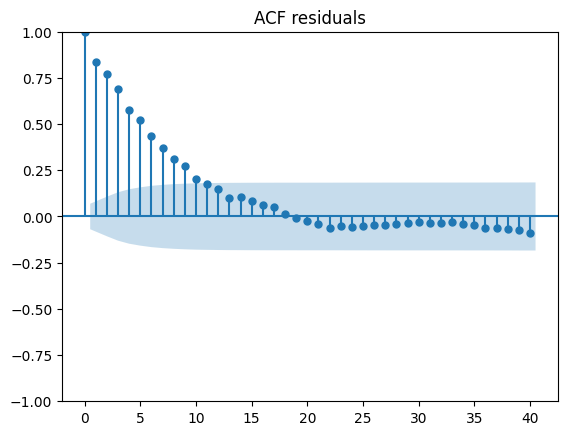

<Figure size 1000x600 with 0 Axes>

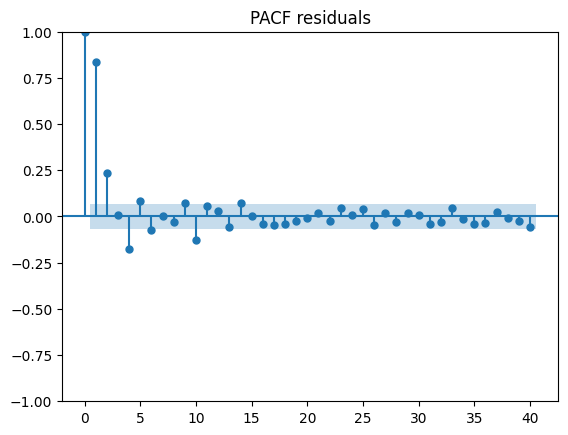

In [8]:
sa.plot_resid_ACF_PACF(model)